In [2]:
import pandas as pd 
import geopandas as gpd 
import osmnx as ox 
from shapely import wkt 

import matplotlib.pyplot as plt 

from tqdm import tqdm 
from glob import glob 


import logging 
# add logger name, time and date to log messages
logging.basicConfig(format='%(asctime)s - %(name)s - %(levelname)s - %(message)s', level=logging.INFO)
log = logging.getLogger("street-clutter")


log.info("Initialization complete.")

2024-05-28 08:03:26,811 - street-clutter - INFO - Initialization complete.


In [3]:
PROJ_CRS = 'EPSG:2263'

In [4]:
# load nyc sidewalk graph 
nyc_sidewalks = gpd.read_file("../data/Sidewalk.geojson").to_crs(PROJ_CRS)

In [5]:
# take a random sample of nyc_sidewalks 
nyc_sidewalks = nyc_sidewalks

In [6]:
# load high-confidence dashcam scaffolding 
dashcam_scaffolding = pd.read_csv("../data/high_confidence_scaffolding.csv", engine='pyarrow')
dashcam_scaffolding = gpd.GeoDataFrame(dashcam_scaffolding, geometry=wkt.loads(dashcam_scaffolding['geometry']), crs=PROJ_CRS)


# read DoB active scaffolding permits 
scaffolding_permits = pd.read_csv("../data/dob_active_sheds.csv", engine='pyarrow')
scaffolding_permits = gpd.GeoDataFrame(scaffolding_permits, geometry=gpd.points_from_xy(scaffolding_permits['Longitude Point'], scaffolding_permits['Latitude Point']), crs='EPSG:4326')
scaffolding_permits = scaffolding_permits.to_crs(PROJ_CRS)

In [7]:
dashcam_scaffolding['latitude'] = dashcam_scaffolding['geometry'].centroid.to_crs('EPSG:4326').y
dashcam_scaffolding['longitude'] = dashcam_scaffolding['geometry'].centroid.to_crs('EPSG:4326').x
dashcam_scaffolding = dashcam_scaffolding[['latitude', 'longitude']]

In [8]:
# read bus stop shelters 
bus_stop_shelters = gpd.read_file("../data/Bus Stop Shelters.geojson").to_crs(PROJ_CRS)
bus_stop_shelters['latitude'] = bus_stop_shelters['latitude'].astype(float)
bus_stop_shelters['longitude'] = bus_stop_shelters['longitude'].astype(float)


In [9]:
# load trash cans 
trash_cans = gpd.read_file("../data/DSNY Litter Basket Inventory_20240525.geojson").to_crs(PROJ_CRS)
trash_cans['longitude'] = trash_cans.geometry.to_crs('EPSG:4326').centroid.x
trash_cans['latitude'] = trash_cans.geometry.to_crs('EPSG:4326').centroid.y

/tmp/ipykernel_1750884/321684515.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  trash_cans['longitude'] = trash_cans.geometry.to_crs('EPSG:4326').centroid.x
/tmp/ipykernel_1750884/321684515.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  trash_cans['latitude'] = trash_cans.geometry.to_crs('EPSG:4326').centroid.y


In [10]:
# load linknyc
linknyc = gpd.read_file("../data/LinkNYC_Kiosk_Locations_20240525.csv")
linknyc = gpd.GeoDataFrame(linknyc, geometry=gpd.points_from_xy(linknyc['Longitude'], linknyc['Latitude']), crs='EPSG:4326').to_crs(PROJ_CRS)

In [11]:
# load bicycle parking shelters 
bicycle_parking_shelters = gpd.read_file("../data/Bicycle Parking Shelters.geojson").to_crs(PROJ_CRS)

In [12]:
# load bicycle racks 
bicycle_racks = gpd.read_file("../data/Bicycle Parking.geojson").to_crs(PROJ_CRS)

In [13]:
# load citybench
citybench = pd.read_csv("../data/City_Bench_Locations__Historical__20240525.csv")
citybench = gpd.GeoDataFrame(citybench, geometry=gpd.points_from_xy(citybench['Longitude'], citybench['Latitude']), crs='EPSG:4326').to_crs(PROJ_CRS)

In [14]:
# sjoin nearest bus stops and trash cans to sidewalk
bus_stop_shelters = gpd.sjoin_nearest(bus_stop_shelters, nyc_sidewalks, how='left', distance_col='distance_to_sidewalk')

In [15]:
# sjoin nearest trash cans to sidewalk
trash_cans = gpd.sjoin_nearest(trash_cans, nyc_sidewalks, how='left', distance_col='distance_to_sidewalk')

In [16]:
# sjoin nearest linknyc to sidewalk
linknyc = gpd.sjoin_nearest(linknyc, nyc_sidewalks, how='left', distance_col='distance_to_sidewalk')

In [17]:
# sjoin nearest citybench 
citybench = gpd.sjoin_nearest(citybench, nyc_sidewalks, how='left', distance_col='distance_to_sidewalk')

In [18]:
# sjoint nearest bicycle parking shelters to sidewalk
bicycle_parking_shelters = gpd.sjoin_nearest(bicycle_parking_shelters, nyc_sidewalks, how='left', distance_col='distance_to_sidewalk')


In [19]:
# sjoin nearest bicycle racks to sidewalk
bicycle_racks = gpd.sjoin_nearest(bicycle_racks, nyc_sidewalks, how='left', distance_col='distance_to_sidewalk')

In [20]:
# now, get number of bus stops, trash cans, linknyc, citybench, bicycle parking shelters, and bicycle racks per sidewalk
bus_stop_counts = bus_stop_shelters.groupby('source_id').size().reset_index(name='bus_stop_count').fillna(0)
trash_can_counts = trash_cans.groupby('source_id').size().reset_index(name='trash_can_count').fillna(0)
linknyc_counts = linknyc.groupby('source_id').size().reset_index(name='linknyc_count').fillna(0)
citybench_counts = citybench.groupby('source_id').size().reset_index(name='citybench_count').fillna(0)
bicycle_parking_shelter_counts = bicycle_parking_shelters.groupby('source_id').size().reset_index(name='bicycle_parking_shelter_count').fillna(0)
bicycle_rack_counts = bicycle_racks.groupby('source_id').size().reset_index(name='bicycle_rack_count').fillna(0)


In [21]:
# merge counts to nyc_sidewalks
nyc_sidewalks = nyc_sidewalks.merge(bus_stop_counts, on='source_id', how='left')
nyc_sidewalks = nyc_sidewalks.merge(trash_can_counts, on='source_id', how='left')
nyc_sidewalks = nyc_sidewalks.merge(linknyc_counts, on='source_id', how='left')
nyc_sidewalks = nyc_sidewalks.merge(citybench_counts, on='source_id', how='left')
nyc_sidewalks = nyc_sidewalks.merge(bicycle_parking_shelter_counts, on='source_id', how='left')
nyc_sidewalks = nyc_sidewalks.merge(bicycle_rack_counts, on='source_id', how='left')


In [22]:
nyc_sidewalks = nyc_sidewalks.fillna(0)

In [23]:
# create a 'clutter' metric that is the sum of all street clutter features
nyc_sidewalks['clutter'] = nyc_sidewalks['bus_stop_count'] + nyc_sidewalks['trash_can_count'] + nyc_sidewalks['linknyc_count'] + nyc_sidewalks['citybench_count'] + nyc_sidewalks['bicycle_parking_shelter_count'] + nyc_sidewalks['bicycle_rack_count']

nyc_sidewalks['clutter'].describe()

count    49479.000000
mean         1.293195
std          3.083396
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max         43.000000
Name: clutter, dtype: float64

In [24]:
nyc_sidewalks['geometry'] = nyc_sidewalks['geometry'].buffer(0.4)

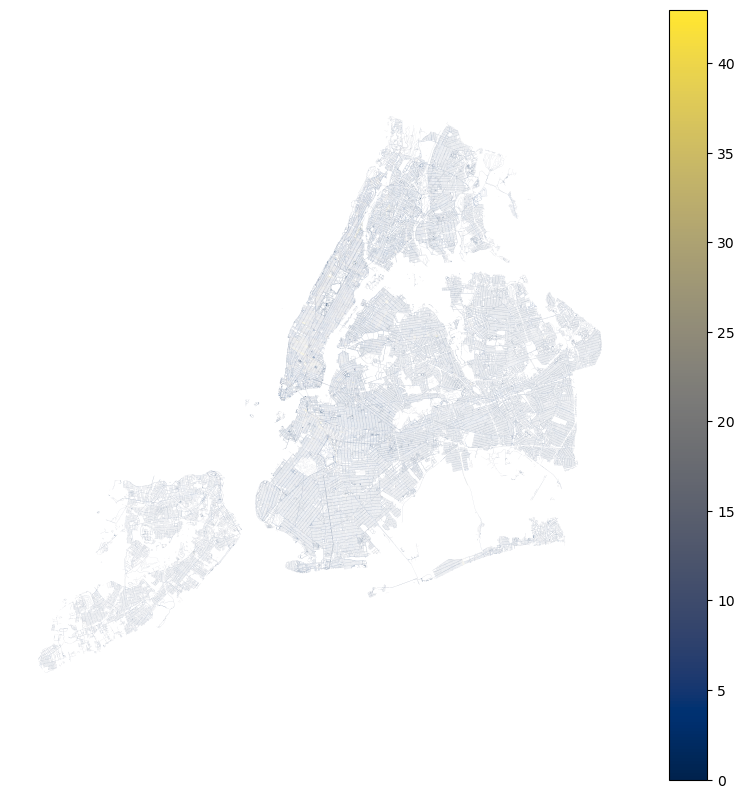

In [25]:
# map sidewalk and color by clutter 
fig, ax = plt.subplots(figsize=(10, 10))
nyc_sidewalks.plot(column='clutter', ax=ax, legend=True, cmap='cividis')
ax.set_axis_off()
plt.show()

In [34]:
# write clutter to csv 
nyc_sidewalks.to_file("../data/nyc_sidewalks_clutter.geojson", driver='GeoJSON')